### This script is used to run the Convolutional Neural Network(CNN) for crop yield forecast
# Step 1: Importing relevant modules

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt # plotting data - matplotlib
import datetime 
import seaborn as sns


from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# Step 2: Get Data

                       WLP           PP
Planting_Date                          
2012-07-27     1054.179321  1054.179321
2012-07-28     1046.297716  1046.297716
2012-07-29     1047.721413  1047.721413
2012-07-30     1125.339227  1125.339227
2012-07-31     1124.212570  1124.212570


<AxesSubplot:title={'center':'Crop Yield Data from WOFOST Simulation'}, xlabel='Planting_Date'>

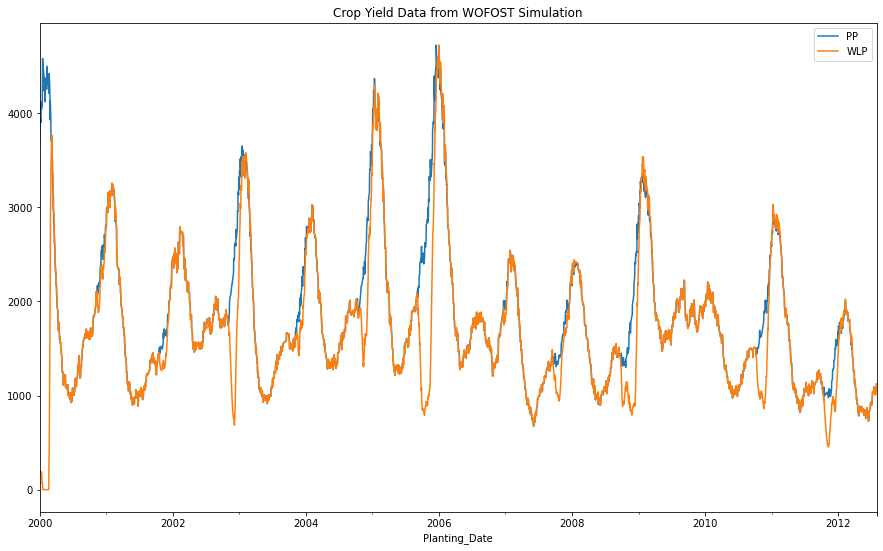

In [2]:
read_csv = os.path.join(os.getcwd(), 'data', 'forML','PPWLP09112021.csv')
vc_yieldWOFOST = pd.read_csv(read_csv, index_col='Planting_Date', parse_dates=True)
# Check the last values from the data obtained
print(vc_yieldWOFOST.tail())
# plotting the original data
vc_yieldWOFOST[['PP', 'WLP']].plot(title='Crop Yield Data from WOFOST Simulation' ,figsize=(15,9))

In [3]:
#Separate PP data from WLP
vc_yieldWOFOSTPP=vc_yieldWOFOST.drop('WLP', 1)
vc_yieldWOFOSTWLP=vc_yieldWOFOST.drop('PP', 1)

#Normalize data
min_max_scaler = preprocessing.MinMaxScaler()
vc_yieldWOFOSTPP = min_max_scaler.fit_transform(vc_yieldWOFOSTPP)
vc_yieldWOFOSTWLP = min_max_scaler.fit_transform(vc_yieldWOFOSTWLP)
#print(vc_yieldWOFOSTWLP)

# Step 3: Build and Run the CNN Model

In [4]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]
 
# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values
 
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))
 
# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_filters, n_kernel, n_epochs, n_batch = config
	# prepare data
	data = series_to_supervised(train, n_in=n_input)
	train_x, train_y = data[:, :-1], data[:, -1]
	train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
	# define model
	model = Sequential()
	model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu', input_shape=(n_input, 1)))
	model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu'))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model
 
# forecast with a pre-fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _, _ = config
	# prepare data
	x_input = array(history[-n_input:]).reshape((1, n_input, 1))
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error
 
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	return scores
 
# summarize model performance
def summarize_scores(name, scores):
	# print a summary
	scores_m, score_std = mean(scores), std(scores)
	print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
	# box and whisker plot
	pyplot.boxplot(scores)
	pyplot.show()
 


In [6]:
# data split
n_test = 1149
# define config
#n_input: The number of lag observations to use as input to the model.
#n_filters: The number of parallel filters.
#n_kernel: The number of time steps considered in each read of the input sequence.
#n_epochs: The number of times to expose the model to the whole training dataset.
#n_batch: The number of samples within an epoch after which the weights are updated.
config = [180, 256, 30, 1, 100]
# grid search
scores = repeat_evaluate(vc_yieldWOFOSTPP, config, n_test)
# summarize scores
summarize_scores('cnn', scores)

 > 0.064
 > 0.087
 > 0.072
 > 0.108
 > 0.067
 > 0.072
 > 0.069
 > 0.076
 > 0.073
 > 0.083
 > 0.073
 > 0.085
 > 0.083
 > 0.084
 > 0.064
 > 0.071
 > 0.079
 > 0.064
 > 0.063
 > 0.054
 > 0.052
 > 0.072
 > 0.090
 > 0.063
 > 0.091


KeyboardInterrupt: 